# APS1052 Final Project - LSTM Bitcoin

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data
The data set is already downloaded for us from the Glassnode

In [32]:
# Load the dataset
file_path = "data/btc_dataset.csv"  # Replace with your dataset path
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

# Preview the data
df.head()


,Closing Price (USD),active_addresses,hash_rate,btc_left,total_addresses,difficulty,total_fees,fed_assets,GLD,IYE,SLV,SPY,TLT,UUP,NYFed_inflation,Google_popularity
Date,,,,,,,,,,,,,,,,
2013-10-01,123.65499,89218,1309351515956620,9220600.0,18656301,639173596179762000,39.139746,3.747387e+06,124.589996,47.430000,20.41,169.339996,105.800003,21.610001,1.738484,3
2013-10-02,125.45500,105303,1307159450402430,9215825.0,18708039,639173596179762000,39.923033,3.747387e+06,127.059998,47.540001,20.92,169.179993,105.959999,21.530001,1.738484,3
2013-10-03,108.58483,89993,1452700445873280,9210850.0,18751619,639173596179762000,36.602946,3.748998e+06,127.180000,47.099998,20.92,167.619995,105.790001,21.510000,1.738484,3
2013-10-04,118.67466,77370,1283409529949880,9206350.0,18791964,639173596179762000,24.772795,3.750609e+06,126.529999,47.520000,20.93,168.889999,105.709999,21.610001,1.738484,3
2013-10-05,121.33866,64961,1602048841926960,9200875.0,18823649,639173596179762000,26.062425,3.752220e+06,126.529999,47.520000,20.93,168.889999,105.709999,21.610001,1.738484,3


Check if there is any missing value.

In [33]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Filter columns with missing values
missing_columns = missing_values[missing_values > 0]

# Display the result
if missing_columns.empty:
    print("No missing values in the dataset.")
else:
    print("Missing values in each column:")
    print(missing_columns)

    # Visualize missing data
    plt.figure(figsize=(12, 6))
    missing_columns.plot(kind='bar', title="Count of Missing Values by Column")
    plt.xlabel("Columns")
    plt.ylabel("Number of Missing Values")
    plt.show()


No missing values in the dataset.


# Loading Data

## Feature Engineering

### 1. Realized Volatility (14-day Rolling)
- **How to Derive**: Compute the rolling standard deviation of the "Closing Price (USD)" log returns over the past 14 days.
- **Implementation**:
    $$
    \text{Realized Volatility} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (\log(P_t/P_{t-1}))^2}
    $$
- **Relevant Columns**: `"Closing Price (USD)"`

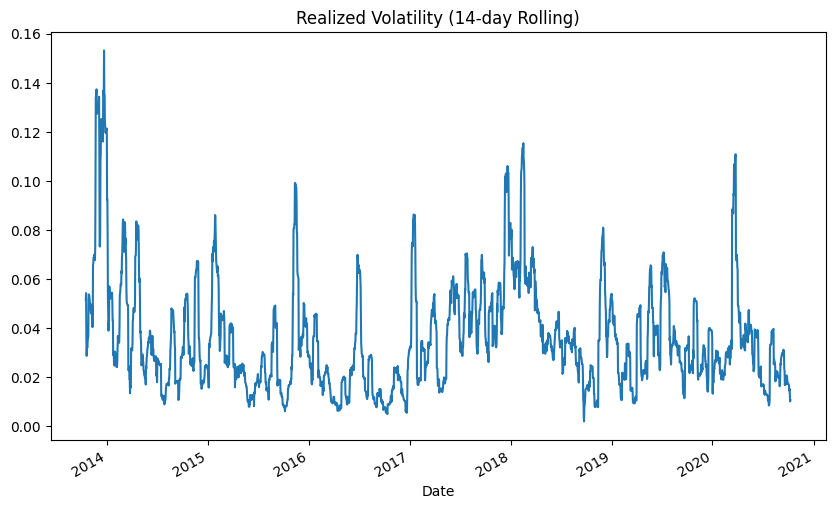

In [34]:
# Calculate log returns
df['log_return'] = np.log(df['Closing Price (USD)'] / df['Closing Price (USD)'].shift(1))

# Calculate realized volatility (14-day rolling standard deviation)
df['realized_volatility'] = df['log_return'].rolling(window=14).std()

# Drop the temporary column
df.drop(columns=['log_return'], inplace=True)

# Visualize the feature
plt.figure(figsize=(10, 6))
df['realized_volatility'].plot(title="Realized Volatility (14-day Rolling)")
plt.show()


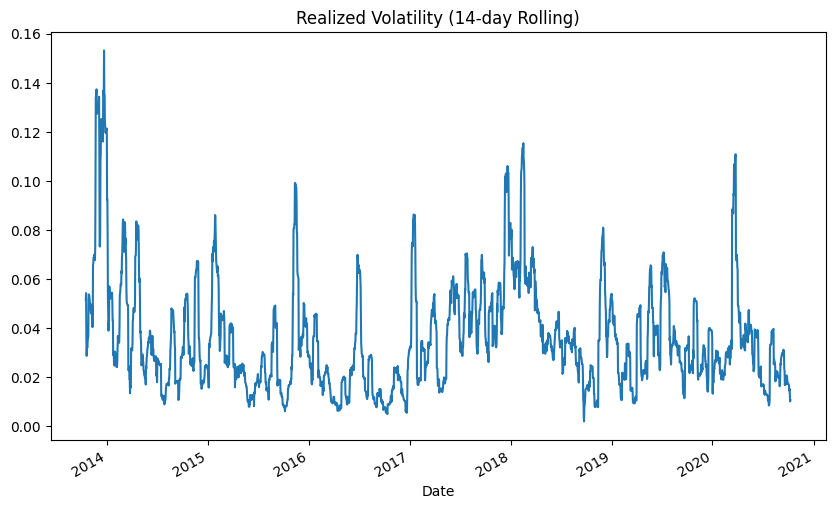

In [35]:
# Calculate log returns
df['log_return'] = np.log(df['Closing Price (USD)'] / df['Closing Price (USD)'].shift(1))

# Calculate realized volatility (14-day rolling standard deviation)
df['realized_volatility'] = df['log_return'].rolling(window=14).std()

# Drop the temporary column
df.drop(columns=['log_return'], inplace=True)

# Visualize the feature
plt.figure(figsize=(10, 6))
df['realized_volatility'].plot(title="Realized Volatility (14-day Rolling)")
plt.show()


#### 2. Exchange Netflow Proxy
- **How to Derive**: Use `"active_addresses"` as a proxy for activity. Calculate the daily change in `"active_addresses"` or the ratio of `"active_addresses"` to `"total_addresses"`. This can act as a proxy for inflow/outflow activity.
- **Implementation**:
$$
     \text{Netflow Proxy} = \frac{\text{active\_addresses}}{\text{total\_addresses}}
     $$
- **Relevant Columns**: `"active_addresses"`, `"total_addresses"`


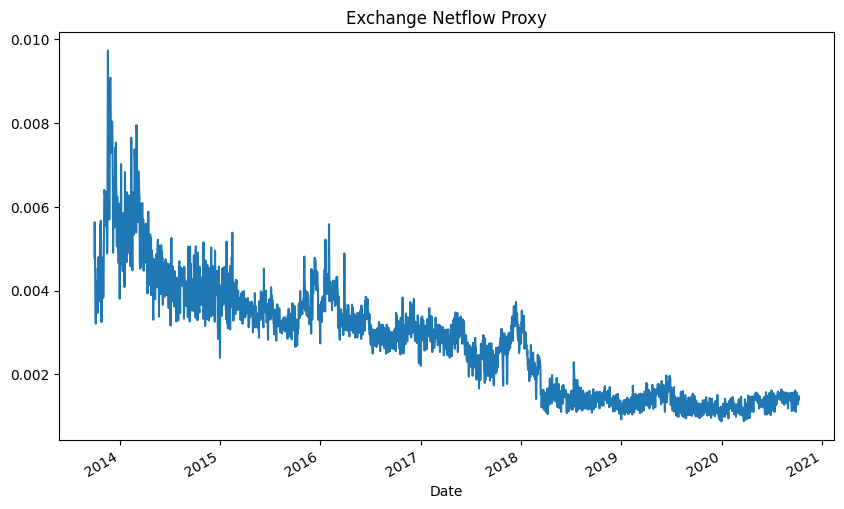

In [36]:
# Ratio of active addresses to total addresses as a proxy for netflow
df['exchange_netflow_proxy'] = df['active_addresses'] / df['total_addresses']

# Visualize the feature
plt.figure(figsize=(10, 6))
df['exchange_netflow_proxy'].plot(title="Exchange Netflow Proxy")
plt.show()


### 3. Social Sentiment Proxy (Google Popularity Change)
- **How to Derive**: Use the percentage change or rolling average of `"Google_popularity"` to capture shifts in public interest over time.
- **Implementation**:
     $$
     \text{Google Sentiment} = \frac{\text{Google\_popularity}_t - \text{Google\_popularity}_{t-1}}{\text{Google\_popularity}_{t-1}}
     $$
- **Relevant Columns**: `"Google_popularity"`

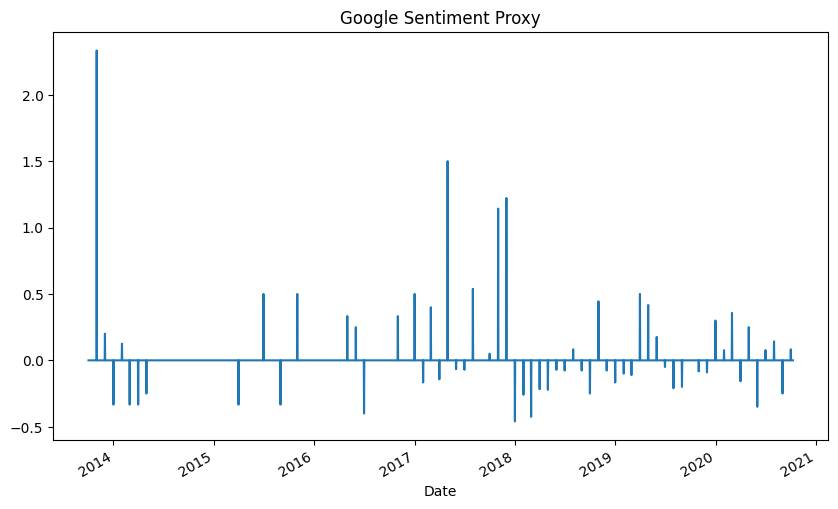

In [37]:
# Percentage change in Google Popularity
df['google_sentiment_proxy'] = df['Google_popularity'].pct_change()

# Visualize the feature
plt.figure(figsize=(10, 6))
df['google_sentiment_proxy'].plot(title="Google Sentiment Proxy")
plt.show()


### 4. Funding Rates Proxy (Mining Cost Ratio)
   - **How to Derive**: Calculate the ratio of `"hash_rate"` to `"difficulty"`, which can act as a proxy for mining costs and potential supply-side pressures.
   - **Implementation**:
     $$
     \text{Mining Cost Ratio} = \frac{\text{hash\_rate}}{\text{difficulty}}
     $$
   - **Relevant Columns**: `"hash_rate"`, `"difficulty"`


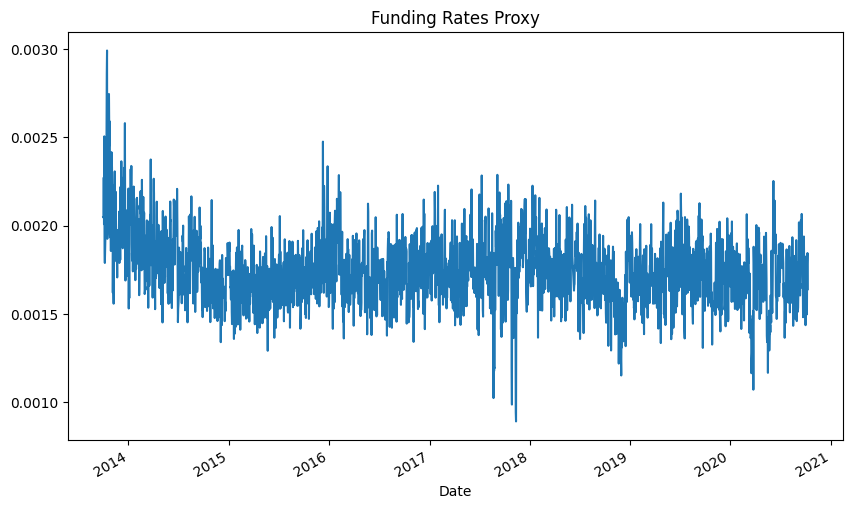

In [38]:
# Convert columns to numeric
df['hash_rate'] = pd.to_numeric(df['hash_rate'], errors='coerce')
df['difficulty'] = pd.to_numeric(df['difficulty'], errors='coerce')

# Mining cost ratio as a proxy for funding rates
df['funding_rate_proxy'] = df['hash_rate'] / df['difficulty']

# Visualize the feature
plt.figure(figsize=(10, 6))
df['funding_rate_proxy'].plot(title="Funding Rates Proxy")
plt.show()


### 5. Macro Interaction Proxy (GLD-SPY Interaction)
   - **How to Derive**: Create interaction terms between `"GLD"` (gold prices) and `"SPY"` (S&P 500 index) to capture broader macroeconomic influences. This could be the product or difference between the two.
   - **Implementation**:
     $$
     \text{GLD-SPY Interaction} = \text{GLD} \times \text{SPY}
     $$
   - **Relevant Columns**: `"GLD"`, `"SPY"`

Check if there is any missing value.

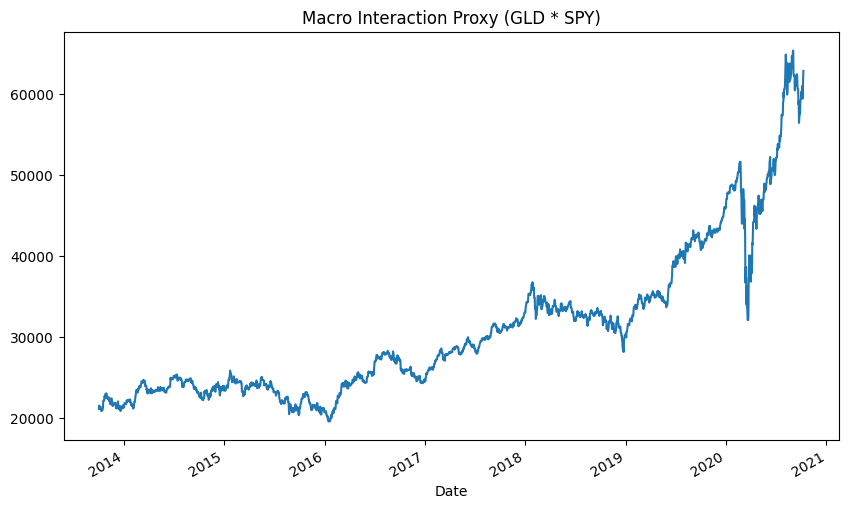

In [39]:
# Interaction between GLD and SPY
df['macro_interaction_proxy'] = df['GLD'] * df['SPY']

# Visualize the feature
plt.figure(figsize=(10, 6))
df['macro_interaction_proxy'].plot(title="Macro Interaction Proxy (GLD * SPY)")
plt.show()


Missing values in each column:
realized_volatility       14
google_sentiment_proxy     1
dtype: int64


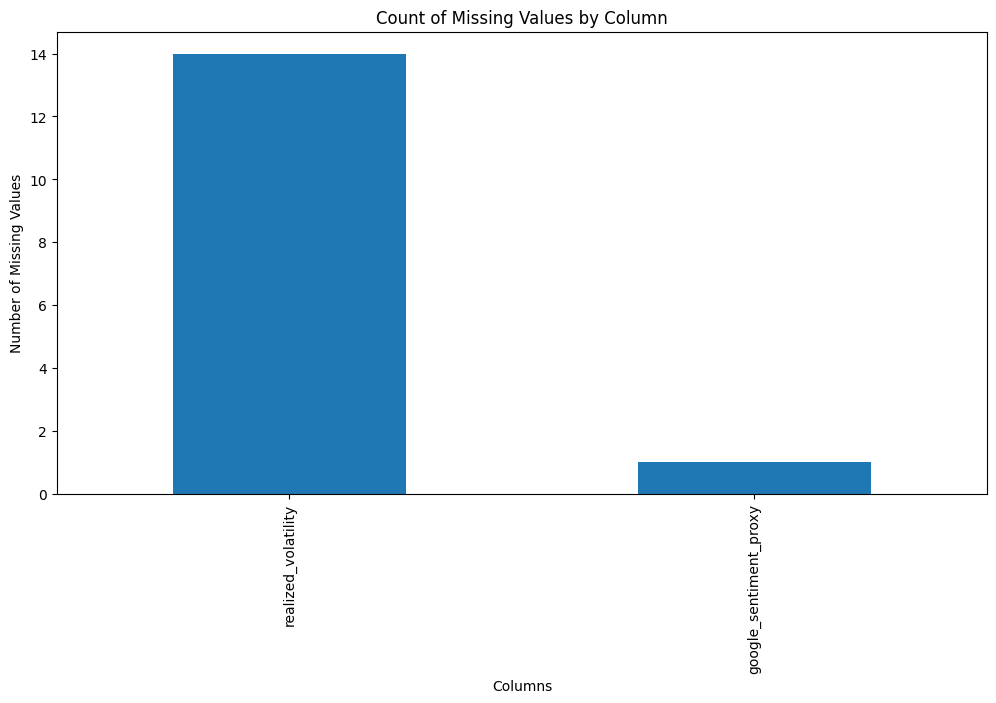

In [40]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Filter columns with missing values
missing_columns = missing_values[missing_values > 0]

# Display the result
if missing_columns.empty:
    print("No missing values in the dataset.")
else:
    print("Missing values in each column:")
    print(missing_columns)

    # Visualize missing data
    plt.figure(figsize=(12, 6))
    missing_columns.plot(kind='bar', title="Count of Missing Values by Column")
    plt.xlabel("Columns")
    plt.ylabel("Number of Missing Values")
    plt.show()


This caused by the way we calculate the two features.
We have two different options:
1. `NaN`
2. `0`

Which Option to Choose?
- **For Long-Term Models or Sparse Data:** Use **Option 1** (`NaN`) and drop rows with missing values. This maintains the integrity of the calculations.
- **For Time Series Models with Long Sequences:** Use **Option 2** (fill with `0`) to avoid breaking sequence continuity.

Since we are working with LSTMs and sequences, Option 2 (setting to `0`) is more practical:
- It avoids disrupting sequences, which is critical for time series models.
- The missing data period (**14** days for volatility, **1** day for sentiment) is short, so the impact of filling with `0` is minimal.


In [41]:
df['realized_volatility'] = df['realized_volatility'].fillna(0)
df['google_sentiment_proxy'] = df['google_sentiment_proxy'].fillna(0)

### Feature Drop
Features with sparse and infrequent activity may not significantly contribute to the model's predictions. As most values in `df['google_sentiment_proxy']` is zero, we decided to drop it.

In [42]:
# Drop the Google Sentiment Proxy column from the dataset
df.drop(columns=['google_sentiment_proxy'], inplace=True)

In [43]:
# Save the current DataFrame to a CSV file
file_path = "data/BTC_data.csv"
df.to_csv(file_path, index=True)

## Dataset Preparation

### Dataset Split

In [44]:
# Define split ratios
train_ratio = 0.64  # 64% for training (80% of Train + Validation)
validation_ratio = 0.16  # 16% for validation (20% of Train + Validation)
test_ratio = 0.20  # 20% for testing

# Calculate indices for splits
train_end_index = int(len(df) * train_ratio)
validation_end_index = int(len(df) * (train_ratio + validation_ratio))

# Sequential split
train_data = df.iloc[:train_end_index]
validation_data = df.iloc[train_end_index:validation_end_index]
test_data = df.iloc[validation_end_index:]

# Print the shapes
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {validation_data.shape}")
print(f"Testing data shape: {test_data.shape}")


Training data shape: (1635, 20)
Validation data shape: (409, 20)
Testing data shape: (512, 20)


### Data Normalization

**Why Normalize Data for Bitcoin Price Prediction?**
Normalization is a crucial preprocessing step for time series forecasting tasks, especially for Bitcoin price prediction, because:

1. **Stabilizing the Scale**:
   - Bitcoin price and other features (e.g., hash rate, difficulty, or macroeconomic factors) can have vastly different scales.
   - Normalizing the data ensures all features are on a similar scale, making it easier for the LSTM to learn patterns.

2. **Improving Model Training**:
   - Models like LSTMs are sensitive to the magnitude of input values. If the input features are not normalized, the gradient updates during training can become unstable.
   - Normalized data ensures smoother gradients and faster convergence.

3. **Relative Changes Over Absolute Values**:
   - For financial data like Bitcoin prices, the relative change in values (e.g., percent change) is often more important than absolute values.
   - By normalizing sequences relative to their starting value (e.g., the first value in each sequence), we emphasize the relative dynamics within the window.

4. **Simplifying Interpretation**:
   - Normalizing data to start at a baseline of 0 makes it easier to interpret the model's output relative to the starting point of the sequence.

**Formula for Normalization:**
The data is normalized using the first value in each sequence as the baseline:
$$
\text{Normalized Value} = \left(\frac{\text{Value}}{\text{First Value}} \right) - 1
$$
This ensures each sequence starts at a normalized value of 0.

---

**Why Use a Window for BTC Forecasting?**
The **lookback window** defines how many past days' data the model considers when making predictions. This choice is important for time series forecasting because:

1. **Capturing Temporal Patterns**:
   - Bitcoin prices and on-chain metrics (e.g., hash rate, active addresses) exhibit temporal dependencies. Using a window allows the model to identify these patterns, such as trends and cycles.

2. **Avoiding Overfitting**:
   - A window that’s too large includes excessive noise and irrelevant data, leading to overfitting.
   - A smaller window focuses on more recent, relevant data, improving model generalization.

3. **Balancing Short-Term and Long-Term Trends**:
   - Bitcoin prices are influenced by both short-term (e.g., market sentiment) and long-term trends (e.g., macroeconomic conditions). The window length determines the balance between these two.

4. **Practicality for Financial Decisions**:
   - In practical trading scenarios, decisions often rely on recent data rather than a full historical analysis. A well-chosen window ensures the model’s output aligns with real-world decision-making.

**Typical Window Setting for BTC:**
- For daily data, a **21-day window** (3 weeks) is used to predict 3 days ahead:
  - Captures short-term trends effectively.
  - Includes enough data to detect meaningful patterns without introducing excessive noise.



In [45]:
# Define the lookback window
lookback_window = 21  # Use the past 21 days to predict the target,
steps_ahead = 3  # Predict 3 days ahead
window = lookback_window + steps_ahead # in total 24 days as a window

# Columns with leading zeros
leading_zeros = ['realized_volatility']


In [46]:
# Function to normalize sequences for training (with leading zero handling)
def normalize_sequences_train(data, columns_with_leading_zeros):
    normalized_data = []
    for i in range(len(data) - window + 1):
        sequence = data.iloc[i:i + window].copy()  # Copy the sequence
        base = sequence.iloc[0].copy()  # Explicitly copy the first row as baseline

        # For problematic columns, find the first non-zero value
        for col in columns_with_leading_zeros:
            non_zero_index = sequence[col].ne(0).idxmax()  # Find the index of the first non-zero value
            if pd.notnull(non_zero_index):  # Ensure the index exists
                base[col] = sequence.loc[non_zero_index, col]  # Set the first non-zero value as the baseline

        # Normalize the sequence
        normalized_sequence = (sequence / base) - 1
        normalized_data.append(normalized_sequence.values)

    return np.array(normalized_data)

# Function to normalize sequences for validation and test (no leading zero handling needed)
def normalize_sequences(data):
    normalized_data = []
    for i in range(len(data) - window + 1):
        sequence = data.iloc[i:i + window].copy()
        base = sequence.iloc[0].copy()
        normalized_sequence = (sequence / base) - 1
        normalized_data.append(normalized_sequence.values)

    return np.array(normalized_data)

# Normalize training data with leading zero handling
train_normalized = normalize_sequences_train(train_data, leading_zeros)

# Normalize validation and test data without leading zero handling
validation_normalized = normalize_sequences(validation_data)
test_normalized = normalize_sequences(test_data)

# Print the shapes of normalized data
print(f"Normalized training data shape: {train_normalized.shape}")
print(f"Normalized validation data shape: {validation_normalized.shape}")
print(f"Normalized testing data shape: {test_normalized.shape}")


Normalized training data shape: (1612, 24, 20)
Normalized validation data shape: (386, 24, 20)
Normalized testing data shape: (489, 24, 20)


Check any `NaN`, `inf` or Anomalous Values in the normalized dataset

In [47]:
# Function to validate normalized data
def validate_normalized_data(normalized_data):
    # Check for NaN values
    nan_count = np.isnan(normalized_data).sum()
    if nan_count > 0:
        print(f"Warning: Found {nan_count} NaN values in the normalized data.")
        normalized_data[np.isnan(normalized_data)] = 0  # Replace NaN with 0

    # Check for Inf values
    inf_count = np.isinf(normalized_data).sum()
    if inf_count > 0:
        print(f"Warning: Found {inf_count} Inf values in the normalized data.")
        normalized_data[np.isinf(normalized_data)] = 0  # Replace Inf with 0

    # Check for negative or unexpected values (optional, based on your use case)
    if (normalized_data < -1).sum() > 0:
        print("Warning: Found values less than -1. Review the normalization process.")

    print("Validation complete. Normalized data is clean.")
    return normalized_data


In [48]:
# Validate the normalized datasets
x_train_normalized = validate_normalized_data(train_normalized)
x_validation_normalized = validate_normalized_data(validation_normalized)
x_test_normalized = validate_normalized_data(test_normalized)


Validation complete. Normalized data is clean.
Validation complete. Normalized data is clean.
Validation complete. Normalized data is clean.


### Y-Values Derivation

We predict 3 days ahead (Multi-Step Predictions), the target value (`y`) corresponds to the `Closing Price (USD)` **3 days after the end of the lookback window**.

In [49]:
target_column = 'Closing Price (USD)'  # The target column

#### Normalized

In [50]:
# Split the normalized data into input (X) and target (y)
def split_x_y(normalized_data, lookback_window, steps_ahead):
    """
    Split normalized data into input (X) and target (y).

    Args:
        normalized_data (np.ndarray): Normalized data with shape (num_windows, window, num_features).
        lookback_window (int): Number of timesteps in the input sequence.
        steps_ahead (int): Number of timesteps in the target sequence.

    Returns:
        tuple: X (inputs) and y (targets).
    """
    # Split the first lookback_window timesteps as X
    X = normalized_data[:, :lookback_window, :]  # Shape: (num_windows, lookback_window, num_features)
    # Split the last steps_ahead timesteps as y
    y = normalized_data[:, lookback_window:, :]  # Shape: (num_windows, steps_ahead, num_features)
    return X, y

# Split the normalized data
X_train_normalized, y_train_normalized = split_x_y(x_train_normalized, lookback_window, steps_ahead)
X_validation_normalized, y_validation_normalized = split_x_y(x_validation_normalized, lookback_window, steps_ahead)
X_test_normalized, y_test_normalized = split_x_y(x_test_normalized, lookback_window, steps_ahead)

# Print the resulting shapes
print(f"Training data shapes: X={X_train_normalized.shape}, y={y_train_normalized.shape}")
print(f"Validation data shapes: X={X_validation_normalized.shape}, y={y_validation_normalized.shape}")
print(f"Testing data shapes: X={X_test_normalized.shape}, y={y_test_normalized.shape}")


Training data shapes: X=(1612, 21, 20), y=(1612, 3, 20)
Validation data shapes: X=(386, 21, 20), y=(386, 3, 20)
Testing data shapes: X=(489, 21, 20), y=(489, 3, 20)


#### Unnormalized

In [51]:
def create_unnormalized_datasets(data, lookback_window, steps_ahead):
    """
    Create input (X) and target (y) datasets without normalization.

    Args:
        data (pd.DataFrame): Raw input data.
        lookback_window (int): Number of timesteps in the input sequence.
        steps_ahead (int): Number of timesteps in the target sequence.

    Returns:
        tuple: X (inputs) and y (targets).
    """
    window = lookback_window + steps_ahead  # Total window size
    X, Y = [], []
    for i in range(len(data) - window + 1):
        # Input: first `lookback_window` timesteps
        X.append(data.iloc[i:i + lookback_window].values)
        # Target: last `steps_ahead` timesteps
        Y.append(data.iloc[i + lookback_window:i + window].values)
    return np.array(X), np.array(Y)


# Create unnormalized datasets
X_train_un, y_train_un = create_unnormalized_datasets(train_data, lookback_window, steps_ahead)
X_validation_un, y_validation_un = create_unnormalized_datasets(validation_data, lookback_window, steps_ahead)
X_test_un, y_test_un = create_unnormalized_datasets(test_data, lookback_window, steps_ahead)

# Print shapes
print(f"Unnormalized Training data shapes: X={X_train_un.shape}, y={y_train_un.shape}")
print(f"Unnormalized Validation data shapes: X={X_validation_un.shape}, y={y_validation_un.shape}")
print(f"Unnormalized Testing data shapes: X={X_test_un.shape}, y={y_test_un.shape}")


Unnormalized Training data shapes: X=(1612, 21, 20), y=(1612, 3, 20)
Unnormalized Validation data shapes: X=(386, 21, 20), y=(386, 3, 20)
Unnormalized Testing data shapes: X=(489, 21, 20), y=(489, 3, 20)


# LSTM Model

## Model Implementation

In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Input, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Model

We use the **Sequence-to-Sequence** (**Seq2Seq**) framework other than a traditional LSTM, as it usually outperforms for multistep forecasting.

In [53]:
def build_seq2seq_model(input_shape, steps_ahead):
    """
    Build a Sequence-to-Sequence model for multistep forecasting.

    Args:
        input_shape (tuple): Shape of the input sequence (timesteps, features).
        steps_ahead (int): Number of steps ahead to predict.

    Returns:
        model: Compiled Seq2Seq model.
    """
    # Encoder
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    encoder_lstm = LSTM(256, return_state=True, name="encoder_lstm")
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

    # Decoder
    decoder_inputs = Input(shape=(1, 1), name="decoder_inputs")  # One timestep, one feature
    decoder_lstm = LSTM(256, return_sequences=True, return_state=True, name="decoder_lstm")
    decoder_dense = Dense(1, activation="linear", name="decoder_dense")  # Predict one output per step

    # Sequentially predict steps_ahead timesteps
    all_outputs = []
    inputs = decoder_inputs
    states = [state_h, state_c]
    for step in range(steps_ahead):
        outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)
        outputs = decoder_dense(outputs)  # Predict the next value
        all_outputs.append(outputs)
        inputs = outputs  # Use the predicted output as the next input
        states = [state_h, state_c]  # Update the decoder states

    # Concatenate all predictions into the final output sequence
    decoder_outputs = Concatenate(axis=1, name="decoder_outputs")(all_outputs)

    # Define the model
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name="seq2seq_model")
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])  # Compile the model
    return model

# Define input shapes
input_shape = (X_train_normalized.shape[1], X_train_normalized.shape[2])  # (lookback_window, num_features)

# Build the model
seq2seq_model = build_seq2seq_model(input_shape, steps_ahead)
seq2seq_model.summary()


Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 21, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    283,648 │ encoder_inputs[0… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 256),  │    264,192 │ decoder_inputs[0… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
│                     │                   │            │ decoder_dense[0]… │
│                     │                   │            │ decoder_lstm[0][… │
│                     │                   │            │ decoder_lstm[0][… │
│                     │                   │            │ decoder_dense[1]… │
│                     │                   │            │ decoder_lstm[1][… │
│                     │                   │            │ decoder_lstm[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 1, 1)      │        257 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │ decoder_lstm[1][… │
│                     │                   │            │ decoder_lstm[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 3, 1)      │          0 │ decoder_dense[0]… │
│ (Concatenate)       │                   │            │ decoder_dense[1]… │
│                     │                   │            │ decoder_dense[2]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 548,097 (2.09 MB)

 Trainable params: 548,097 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

### Normalized

In [54]:
# Extract the target feature (e.g., "Closing Price (USD)") for decoder outputs
target_index = 0  # Assuming the target feature is the first feature in y
y_train_normalized_target = y_train_normalized[:, :, [target_index]]
y_validation_normalized_target = y_validation_normalized[:, :, [target_index]]
y_test_normalized_target = y_test_normalized[:, :, [target_index]]

# Use the first timestep of `y` as the decoder input during training
decoder_input_train = y_train_normalized_target[:, :1, :]  # Shape: (num_samples, 1, 1)
decoder_input_validation = y_validation_normalized_target[:, :1, :]  # Shape: (num_samples, 1, 1)

In [55]:
# Directory to save the model
normalized_model_save_path = "best_seq2seq_model.keras"

# Callbacks
callbacks = [
    ModelCheckpoint(
        filepath=normalized_model_save_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

# Train the model with callbacks
history = seq2seq_model.fit(
    [X_train_normalized, decoder_input_train],
    y_train_normalized_target,
    validation_data=([X_validation_normalized, decoder_input_validation], y_validation_normalized_target),
    epochs=50,  # Number of epochs
    batch_size=32,  # Mini-batch size
    verbose=1,
    callbacks=callbacks
)

# Find the best epoch based on the lowest validation loss
best_epoch_normalized = np.argmin(history.history['val_loss'])
print(f"The best model was saved at epoch: {best_epoch_normalized + 1}")


Epoch 1/50
49/51 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0618 - mae: 0.1364
Epoch 1: val_loss improved from inf to 0.00922, saving model to best_seq2seq_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.0600 - mae: 0.1343 - val_loss: 0.0092 - val_mae: 0.0717 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0162 - mae: 0.0731
Epoch 2: val_loss improved from 0.00922 to 0.00488, saving model to best_seq2seq_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0161 - mae: 0.0730 - val_loss: 0.0049 - val_mae: 0.0492 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0116 - mae: 0.0595
Epoch 3: val_loss improved from 0.00488 to 0.00376, saving model to best_seq2seq_model.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0115 - mae: 0.0595 - val_loss: 0.0038 - val_mae: 0.0445 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0079 - mae: 0.0520
Epoch 4: val_lo

### Unnormalized

In [56]:
# Extract the target feature (e.g., "Closing Price (USD)") for decoder outputs
target_index = 0  # Assuming the target feature is the first feature in y
y_train_un_target = y_train_un[:, :, [target_index]]
y_validation_un_target = y_validation_un[:, :, [target_index]]
y_test_un_target = y_test_un[:, :, [target_index]]

# Use the first timestep of `y` as the decoder input during training
decoder_input_train_un = y_train_un_target[:, :1, :]  # Shape: (num_samples, 1, 1)
decoder_input_validation_un = y_validation_un_target[:, :1, :]  # Shape: (num_samples, 1, 1)

# Build the model
seq2seq_model_un = build_seq2seq_model(input_shape=(X_train_un.shape[1], X_train_un.shape[2]), steps_ahead=steps_ahead)
seq2seq_model_un.summary()


Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs      │ (None, 21, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_inputs      │ (None, 1, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 256),     │    283,648 │ encoder_inputs[0… │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 256),  │    264,192 │ decoder_inputs[0… │
│                     │ (None, 256),      │            │ encoder_lstm[0][… │
│                     │ (None, 256)]      │            │ encoder_lstm[0][… │
│                     │                   │            │ decoder_dense[0]… │
│                     │                   │            │ decoder_lstm[0][… │
│                     │                   │            │ decoder_lstm[0][… │
│                     │                   │            │ decoder_dense[1]… │
│                     │                   │            │ decoder_lstm[1][… │
│                     │                   │            │ decoder_lstm[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 1, 1)      │        257 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │ decoder_lstm[1][… │
│                     │                   │            │ decoder_lstm[2][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_outputs     │ (None, 3, 1)      │          0 │ decoder_dense[0]… │
│ (Concatenate)       │                   │            │ decoder_dense[1]… │
│                     │                   │            │ decoder_dense[2]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 548,097 (2.09 MB)

 Trainable params: 548,097 (2.09 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
# Define callbacks
unnormalized_model_save_path = "best_seq2seq_model_unnormalized.keras"
callbacks_un = [
    ModelCheckpoint(
        filepath=unnormalized_model_save_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.1,
        patience=3,
        verbose=1
    ),
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        verbose=1,
        restore_best_weights=True
    )
]

# Train the Seq2Seq model
history_un = seq2seq_model_un.fit(
    [X_train_un, decoder_input_train_un],
    y_train_un_target,
    validation_data=([X_validation_un, decoder_input_validation_un], y_validation_un_target),
    epochs=50,  # Number of epochs
    batch_size=32,  # Mini-batch size
    verbose=1,
    callbacks=callbacks_un
)

# Find the best epoch based on the lowest validation loss
best_epoch_un = np.argmin(history_un.history['val_loss'])
print(f"The best model was saved at epoch: {best_epoch_un + 1}")


Epoch 1/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 12634347.0000 - mae: 1703.2188
Epoch 1: val_loss improved from inf to 35866408.00000, saving model to best_seq2seq_model_unnormalized.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - loss: 12657639.0000 - mae: 1705.3347 - val_loss: 35866408.0000 - val_mae: 5741.0610 - learning_rate: 0.0010
Epoch 2/50
50/51 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 12552729.0000 - mae: 1678.7714
Epoch 2: val_loss improved from 35866408.00000 to 35697832.00000, saving model to best_seq2seq_model_unnormalized.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 12576875.0000 - mae: 1681.1709 - val_loss: 35697832.0000 - val_mae: 5726.3628 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 13184743.0000 - mae: 1758.9869
Epoch 3: val_loss improved from 35697832.00000 to 35545736.00000, saving model to best_seq2seq_model_unnormalized.keras
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 13183727.0000 - mae: 1758.3735 - 

## Training Progress Visualization

### Normalized

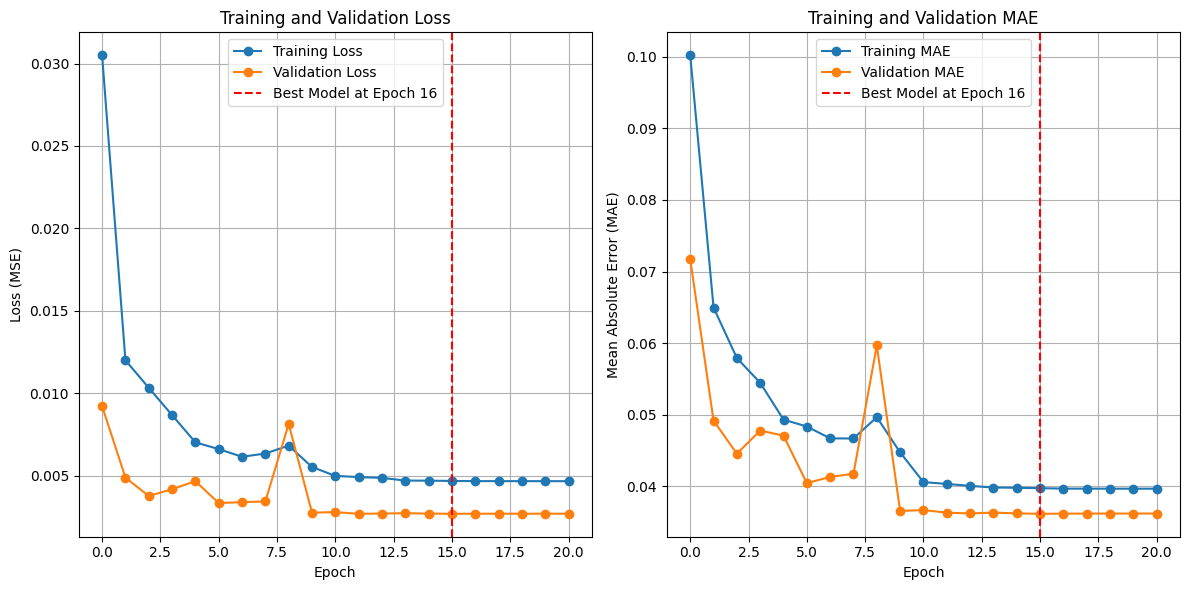

In [58]:
# Extract loss and MAE values
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
train_mae = history.history["mae"]
val_mae = history.history["val_mae"]


# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)  # Create a 1x2 grid, first plot
plt.plot(train_loss, label="Training Loss", marker="o")
plt.plot(val_loss, label="Validation Loss", marker="o")
plt.axvline(best_epoch_normalized, color="r", linestyle="--", label=f"Best Model at Epoch {best_epoch_normalized+ 1}")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

# MAE Plot
plt.subplot(1, 2, 2)  # Create a 1x2 grid, second plot
plt.plot(train_mae, label="Training MAE", marker="o")
plt.plot(val_mae, label="Validation MAE", marker="o")
plt.axvline(best_epoch_normalized, color="r", linestyle="--", label=f"Best Model at Epoch {best_epoch_normalized + 1}")
plt.title("Training and Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Unnormalized

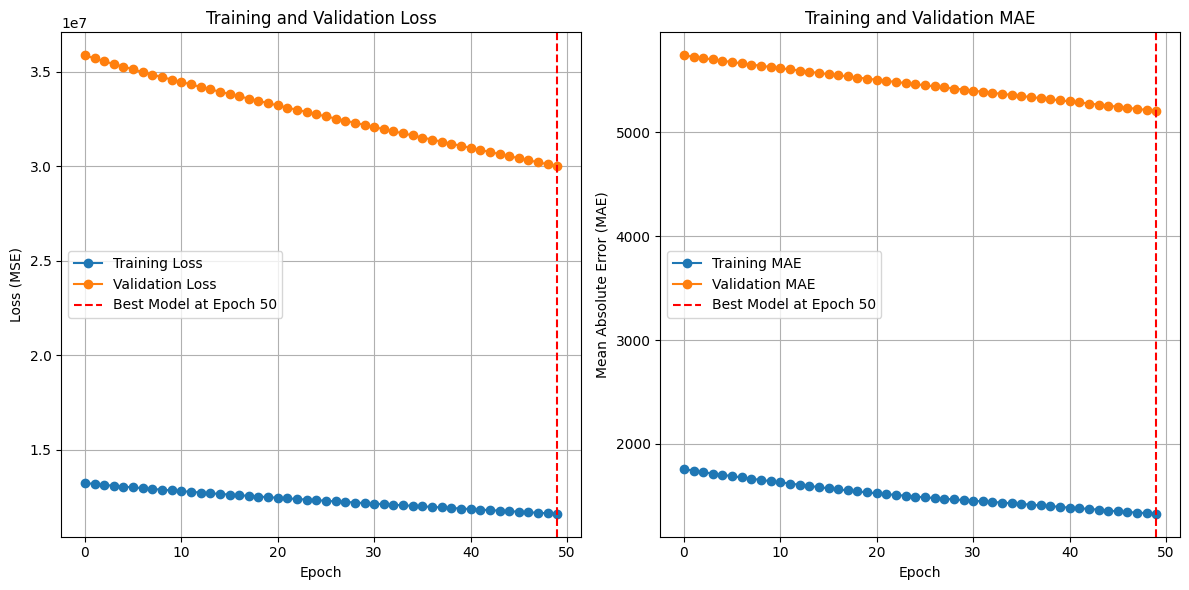

In [61]:
# Extract loss and MAE values
train_loss_un = history_un.history["loss"]
val_loss_un = history_un.history["val_loss"]
train_mae_un = history_un.history["mae"]
val_mae_un = history_un.history["val_mae"]


# Plot the training and validation loss
plt.figure(figsize=(12, 6))

# Loss Plot
plt.subplot(1, 2, 1)  # Create a 1x2 grid, first plot
plt.plot(train_loss_un, label="Training Loss", marker="o")
plt.plot(val_loss_un, label="Validation Loss", marker="o")
plt.axvline(best_epoch_un, color="r", linestyle="--", label=f"Best Model at Epoch {best_epoch_un+ 1}")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)

# MAE Plot
plt.subplot(1, 2, 2)  # Create a 1x2 grid, second plot
plt.plot(train_mae_un, label="Training MAE", marker="o")
plt.plot(val_mae_un, label="Validation MAE", marker="o")
plt.axvline(best_epoch_un, color="r", linestyle="--", label=f"Best Model at Epoch {best_epoch_un + 1}")
plt.title("Training and Validation MAE")
plt.xlabel("Epoch")
plt.ylabel("Mean Absolute Error (MAE)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Model Evaluation with Test Dataset

### Normalized

In [64]:
# Extract the first timestep of the test target as the decoder input
decoder_input_test_normalized = y_test_normalized_target[:, :1, :]  # Shape: (num_samples, 1, 1)

# Load the best saved normalized model
best_model_normalized = tf.keras.models.load_model("best_seq2seq_model.keras")

# Predict on the test set
predictions_normalized = best_model_normalized.predict(
    [X_test_normalized, decoder_input_test_normalized],
    verbose=1
)

# Print prediction shapes for verification
print(f"Normalized Test Predictions Shape: {predictions_normalized.shape}")



16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step
Normalized Test Predictions Shape: (489, 3, 1)


In [66]:
# Calculate evaluation metrics for normalized test data
mse_normalized = np.mean((predictions_normalized - y_test_normalized_target)**2)
mae_normalized = np.mean(np.abs(predictions_normalized - y_test_normalized_target))

print(f"Normalized Test MSE: {mse_normalized:.4f}")
print(f"Normalized Test MAE: {mae_normalized:.4f}")


Normalized Test MSE: 0.0030
Normalized Test MAE: 0.0400


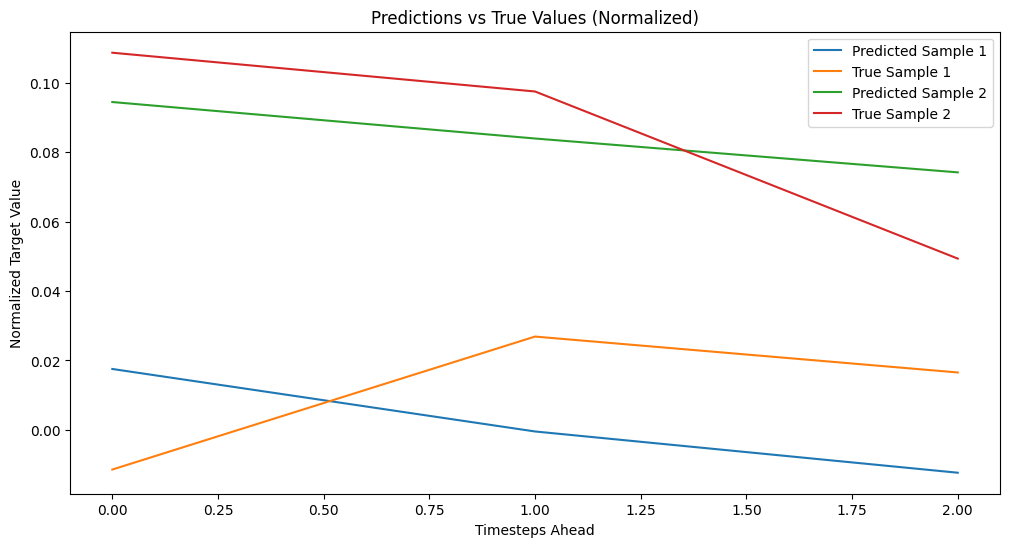

In [69]:
# Plot predictions vs true values for the first few samples
plt.figure(figsize=(12, 6))
for i in range(2):  # Visualize first 5 samples
    plt.plot(predictions_normalized[i, :, 0], label=f"Predicted Sample {i+1}")
    plt.plot(y_test_normalized_target[i, :, 0], label=f"True Sample {i+1}")
plt.title("Predictions vs True Values (Normalized)")
plt.xlabel("Timesteps Ahead")
plt.ylabel("Normalized Target Value")
plt.legend()
plt.show()


### Unnormalized

In [65]:
# Extract the first timestep of the test target as the decoder input
decoder_input_test_un = y_test_un[:, :1, [target_index]]  # Shape: (num_samples, 1, 1)

# Load the best saved unnormalized model (if saved separately)
best_model_unnormalized = tf.keras.models.load_model("best_seq2seq_model_unnormalized.keras")

# Predict on the test set
predictions_unnormalized = best_model_unnormalized.predict(
    [X_test_un, decoder_input_test_un],
    verbose=1
)

# Print prediction shapes for verification
print(f"Unnormalized Test Predictions Shape: {predictions_unnormalized.shape}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Unnormalized Test Predictions Shape: (489, 3, 1)


In [67]:
# Calculate evaluation metrics for unnormalized test data
mse_unnormalized = np.mean((predictions_unnormalized - y_test_un[:, :, [target_index]])**2)
mae_unnormalized = np.mean(np.abs(predictions_unnormalized - y_test_un[:, :, [target_index]]))

print(f"Unnormalized Test MSE: {mse_unnormalized:.4f}")
print(f"Unnormalized Test MAE: {mae_unnormalized:.4f}")


Unnormalized Test MSE: 77739752.9957
Unnormalized Test MAE: 8683.8471


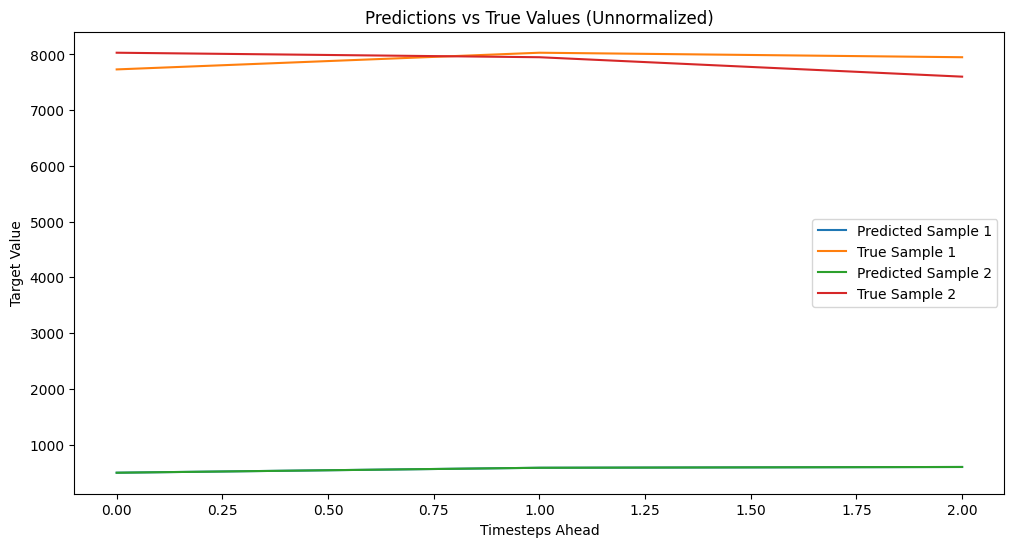

In [71]:
# Plot predictions vs true values for the first few samples
plt.figure(figsize=(12, 6))
for i in range(2):  # Visualize first 5 samples
    plt.plot(predictions_unnormalized[i, :, 0], label=f"Predicted Sample {i+1}")
    plt.plot(y_test_un[i, :, target_index], label=f"True Sample {i+1}")
plt.title("Predictions vs True Values (Unnormalized)")
plt.xlabel("Timesteps Ahead")
plt.ylabel("Target Value")
plt.legend()
plt.show()
